In [25]:
import json, numpy as np, pandas as pd, random
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt
from collections import Counter

model_clean_names = {"gpt4o": "GPT-4o", "claude3.5-sonnet": "Claude3.5-S", "llama370B": "Llama3-70b"}

writing_errors_palette = {
    'Lack of Specificity and Detail': '#E0E0E0',  # Light Grey
    'Awkward Word Choice and Phrasing': '#FFA07A',  # Light Salmon
    'Purple Prose': '#9370DB',  # Medium Purple
    'Unnecessary/Redundant Exposition': '#90EE90',  # Light Green
    'Cliche': '#FFD700',  # Gold
    'Poor Sentence Structure': '#FF6347',  # Tomato
    'Tense Inconsistency': '#4682B4'  # Steel Blue
}

with open('all_finegrained_clean.json') as f:
    data = json.load(f)
sources = list(set([d["source"] for d in data]))

for d in data:
    if d["type"] != "Literary Fiction":
        d["type"] = "Creative NonFiction"
    for edit in d["fine_grained_edits"]:
        edit["categorization"] = edit["categorization"].replace("/ ", "/").replace(" (Unnecessary ornamental and overly verbose)", "")
        char_diff = len(edit["editedText"]) - len(edit["originalText"])
        # if len(edit["originalText"]) < 10 and len(edit["editedText"]) > 10:
        if char_diff > 40:
            edit['type'] = "Insert"
        elif char_diff < -40 or edit["originalText"] == "":
            edit['type'] = "Delete"
        else:
            edit["type"] = "Replace"

    d["editor"] = d["id"].split("_")[0]
    d["creativity_pre_score"] = int(d["creativity_scores"][0])
    d["creativity_post_score"] = int(d["creativity_scores"][1])
    d["creativity_diff_score"] = d["creativity_post_score"] - d["creativity_pre_score"]
editors = list(set([d["editor"] for d in data]))

# Get the distributions of creativity scores per editor
editor_scores = {editor: [] for editor in editors}
editor_pre_scores = {editor: [] for editor in editors}
editor_post_scores = {editor: [] for editor in editors}

for d in data:
    editor_scores[d["editor"]].append(d["creativity_pre_score"])
    editor_scores[d["editor"]].append(d["creativity_post_score"])
    editor_pre_scores[d["editor"]].append(d["creativity_pre_score"])
    editor_post_scores[d["editor"]].append(d["creativity_post_score"])

# print avg and std of creativity scores per editor
editor_means, editor_stds = {}, {}
for editor in editors:
    editor_means[editor] = np.mean(editor_scores[editor])
    editor_stds[editor] = np.std(editor_scores[editor])

# Calculate a creativity z-score for each editor
for d in data:
    d["creativity_z_score_pre"] = (d["creativity_pre_score"] - editor_means[d["editor"]]) / editor_stds[d["editor"]]
    d["creativity_z_score_post"] = (d["creativity_post_score"] - editor_means[d["editor"]]) / editor_stds[d["editor"]]

min_z_score = min([d["creativity_z_score_pre"] for d in data] + [d["creativity_z_score_post"] for d in data])
max_z_score = max([d["creativity_z_score_pre"] for d in data] + [d["creativity_z_score_post"] for d in data])
# renormalize z-scores to be between 0 and 10
for d in data:
    d["creativity_z_score_pre"] = 10 * (d["creativity_z_score_pre"] - min_z_score) / (max_z_score - min_z_score)
    d["creativity_z_score_post"] = 10 * (d["creativity_z_score_post"] - min_z_score) / (max_z_score - min_z_score)
    d["creativity_z_score_pre_int"] = int(d["creativity_z_score_pre"])
    d["creativity_z_score_post_int"] = int(d["creativity_z_score_post"])
    d["creativity_z_score_diff"] = d["creativity_z_score_post_int"] - d["creativity_z_score_pre_int"]

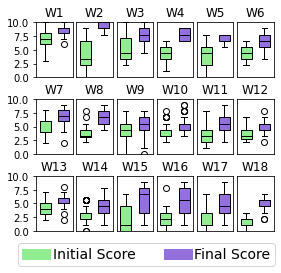

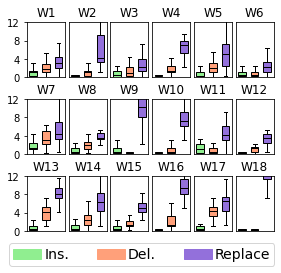

In [22]:
# plot is with 6x3 boxplots
fig, axs = plt.subplots(3, 6, figsize=(4, 3.5))
editors = sorted(editors, key=lambda x: editor_means[x], reverse=True)
for i, editor in enumerate(editors):
    ax = axs[i//6, i%6]
    # ax.boxplot(
    # editor_scores[editor], patch_artist=True, boxprops=dict(facecolor='#90EE90', color='black'), whiskerprops=dict(color='black'), medianprops=dict(color='black'), capprops=dict(color='black'))
    # plot both pre and post scores, keep green for pre, and use purple for post, using positions 1 and 2
    ax.boxplot(editor_pre_scores[editor], patch_artist=True, boxprops=dict(facecolor='#90EE90', color='black'), whiskerprops=dict(color='black'), medianprops=dict(color='black'), capprops=dict(color='black'), positions=[1], widths=0.6)
    ax.boxplot(editor_post_scores[editor], patch_artist=True, boxprops=dict(facecolor='#9370DB', color='black'), whiskerprops=dict(color='black'), medianprops=dict(color='black'), capprops=dict(color='black'), positions=[2], widths=0.6)
    ax.set_title(f"W{i+1}")
    ax.set_ylim(1, 10)
    ax.set_yticks(([] if i % 6 != 0 else [0, 2.5, 5, 7.5, 10]))
    ax.set_xticks([])

pre_patch = mpatches.Patch(color='#90EE90', label='Initial Score')
post_patch = mpatches.Patch(color='#9370DB', label='Final Score')

fig.tight_layout(h_pad=-0.5, w_pad=0)
fig.legend(handles=[pre_patch, post_patch], loc='lower left', bbox_to_anchor=(0.05, -0.10), ncol=2, fontsize=14, handletextpad=0.2, labelspacing=0.3, borderpad=0.3)
fig.tight_layout(h_pad=0.0, w_pad=-0.5)
plt.subplots_adjust(wspace=0.1)
plt.savefig("figures/Figure_Pre_Post_Scores.pdf", bbox_inches='tight')
plt.show()

# do the same plot based on the number of insertions, deletions, and replacements
fig, axs = plt.subplots(3, 6, figsize=(4, 3.5))
for i, editor in enumerate(editors):
    ax = axs[i//6, i%6]
    samples = [d for d in data if d["editor"] == editor]
    N_inserts = [len([edit for edit in d["fine_grained_edits"] if edit["type"] == "Insert"])+0.5*random.random() for d in samples]
    N_deletes = [len([edit for edit in d["fine_grained_edits"] if edit["type"] == "Delete"])+0.5*random.random() for d in samples]
    N_replaces = [len([edit for edit in d["fine_grained_edits"] if edit["type"] == "Replace"])+0.5*random.random() for d in samples]
    # print(N_inserts, N_deletes, N_replaces)
    ax.boxplot(N_inserts, patch_artist=True, boxprops=dict(facecolor='#90EE90', color='black'), whiskerprops=dict(color='black'), medianprops=dict(color='black'), capprops=dict(color='black'), positions=[1], widths=0.6, showfliers=False)
    ax.boxplot(N_deletes, patch_artist=True, boxprops=dict(facecolor='#FFA07A', color='black'), whiskerprops=dict(color='black'), medianprops=dict(color='black'), capprops=dict(color='black'), positions=[2], widths=0.6, showfliers=False)
    ax.boxplot(N_replaces, patch_artist=True, boxprops=dict(facecolor='#9370DB', color='black'), whiskerprops=dict(color='black'), medianprops=dict(color='black'), capprops=dict(color='black'), positions=[3], widths=0.6, showfliers=False)
    ax.set_title(f"W{i+1}")
    ax.set_ylim(0, 12)
    ax.set_yticks(([] if i % 6 != 0 else [0, 4, 8, 12]))
    ax.set_xticks([])
insert_patch = mpatches.Patch(color='#90EE90', label='Ins.')
delete_patch = mpatches.Patch(color='#FFA07A', label='Del.')
replace_patch = mpatches.Patch(color='#9370DB', label='Replace')

fig.legend(handles=[insert_patch, delete_patch, replace_patch], loc='lower left', bbox_to_anchor=(0.02, -0.10), ncol=3, fontsize=14, handletextpad=0.2, labelspacing=0.3, borderpad=0.3)
fig.tight_layout(h_pad=0.0, w_pad=-0.5)
plt.subplots_adjust(wspace=0.1)
plt.savefig("figures/Figure_Edit_Operations.pdf", bbox_inches='tight')
plt.show()

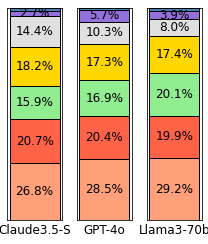

In [125]:
# plot histogram of errors / model
categories = set(e["categorization"] for d in data for e in d["fine_grained_edits"])

# compute total percentages
total_cat_percentages = Counter(e["categorization"] for d in data for e in d["fine_grained_edits"])
total_edits = sum(total_cat_percentages.values())
total_cat_percentages = {cat: (total_cat_percentages[cat] / total_edits) * 100 for cat in categories}

categories = sorted([cat for cat in categories if total_cat_percentages[cat] > 0.5], key=lambda x: total_cat_percentages[x], reverse=True)

fig, axs = plt.subplots(1, 3, figsize=(3.0, 3.5))

i2pos = {0: 0.5, 1: 1.0, 2: 1.5}

for i, source in enumerate(sorted(sources)):
    ax = axs[i]
    samples = [d for d in data if d["source"] == source]
    errors = [edit["categorization"] for d in samples for edit in d["fine_grained_edits"]]
    errors = [e for e in errors if e in writing_errors_palette]
    counts = Counter(errors)
    percs = {k: 100.0*v/len(errors) for k, v in counts.items()}

    left = 0.0
    for j, k in enumerate(categories):
        perc = percs.get(k, 0)
        ax.bar(i2pos[i], perc, bottom=left, color=writing_errors_palette[k], edgecolor='black', width=bar_width)
        if perc > 2.5:
            ax.text(i2pos[i], left + perc/2, f"{perc:.1f}%", ha='center', va='center', color='black', fontsize=12)
        left += perc
    ax.set_ylim(0, 100)
    ax.set_yticks([])
    ax.set_xlabel(model_clean_names[source], fontsize=12)
    ax.set_xticks([])
    
fig.tight_layout(h_pad=0.0, w_pad=1.5)
plt.savefig("figures/Figure_Model_Error_Categories.pdf", bbox_inches='tight')
plt.show()

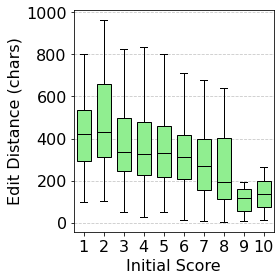

In [69]:
import Levenshtein

def plot_whisker_plots(pre_scores, vals, title="", ylabel='Value', fn=None):
    score_edits = {}
    for score, edits in zip(pre_scores, vals):
        if score not in score_edits:
            score_edits[score] = []
        score_edits[score].append(edits)
    sorted_scores = sorted(score_edits.keys())
    plt.figure(figsize=(4, 4))
    plt.boxplot([score_edits[score] for score in sorted_scores], patch_artist=True, boxprops=dict(facecolor='#90EE90', color='black'), whiskerprops=dict(color='black'), medianprops=dict(color='black'), capprops=dict(color='black'), widths=0.7, showfliers=False)
    plt.xlabel("Initial Score", fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.xticks(range(1, len(sorted_scores) + 1), sorted_scores, fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    if fn:
        plt.savefig(fn)
    plt.show()

pre_scores = [d["creativity_pre_score"] for d in data]
num_edits = [len(d["fine_grained_edits"]) for d in data]
edit_ratios = [Levenshtein.ratio(d["preedit"], d["postedit"]) for d in data]
edit_distances = [Levenshtein.distance(d["preedit"], d["postedit"]) for d in data]

# plot_whisker_plots(pre_scores, num_edits, title="Distribution of Edits by Creativity Pre-Score", ylabel="#Edits", fn="figures/Figure_num_edits.png")
# plot_whisker_plots(pre_scores, edit_ratios, title="Distribution of Edit Ratios by Creativity Pre-Score", ylabel="Edit Ratio", fn="figures/Figure_edit_ratios.png")
plot_whisker_plots(pre_scores, edit_distances, fn="figures/Figure_Edit_Distance.pdf", ylabel="Edit Distance (chars)")


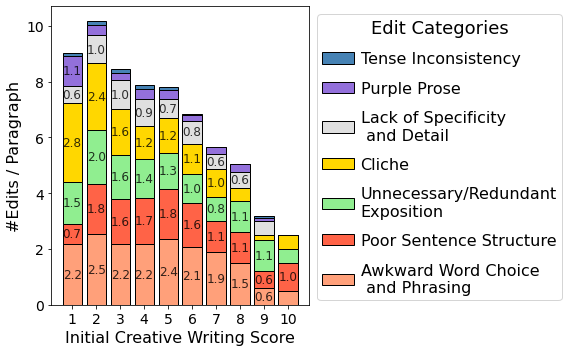

In [61]:
# Categorization of edits per pre-score
from collections import Counter
import matplotlib.colors

score_key = "creativity_pre_score"
# score_key = "creativity_z_score_pre_int"

pre_edit_scores = sorted(set(d[score_key] for d in data))

# Prepare data for plotting
# plot_data = []
# for pre_edit_score in pre_edit_scores:
#     data_score = [d for d in data if d[score_key] == pre_edit_score]
#     all_categories = Counter(e["categorization"] for d in data_score for e in d["fine_grained_edits"] if e["categorization"] in categories)
#     total_edits = sum(all_categories.values())
#     category_percentages = {cat: (all_categories[cat] / total_edits) * 100 for cat in categories}
#     plot_data.append(category_percentages)

# fig, ax = plt.subplots(figsize=(10, 5))
# bottom = np.zeros(len(pre_edit_scores))
# for category in categories:
#     percentages = [d.get(category, 0) for d in plot_data]
#     ax.bar(pre_edit_scores, percentages, bottom=bottom, label=category, color=writing_errors_palette[category])
#     bottom += percentages

# # Customize the plot
# ax.set_title('Distribution of Edit Categories by Pre-Score')
# ax.set_xlabel('Pre-Score')
# ax.set_ylabel('Percentage of Edits')
# ax.set_ylim(0, 100)
# ax.legend(title='Edit Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

def darken_color(color, factor=0.7):
    """ Darken a given color by a factor. """
    return tuple(max(0, min(c * factor, 1)) for c in matplotlib.colors.to_rgb(color))

category2wrapped = {
    'Lack of Specificity and Detail': 'Lack of Specificity\n and Detail',
    'Awkward Word Choice and Phrasing': 'Awkward Word Choice\n and Phrasing',
    'Unnecessary/Redundant Exposition': "Unnecessary/Redundant\nExposition"
}

plot_data = []
for pre_edit_score in pre_edit_scores:
    data_score = [d for d in data if d[score_key] == pre_edit_score]
    all_categories = Counter(e["categorization"] for d in data_score for e in d["fine_grained_edits"] if e["categorization"] in categories)
    total_edits = sum(all_categories.values())
    all_categories = {cat: all_categories[cat] / len(data_score) for cat in categories}
    plot_data.append(all_categories)

fig, ax = plt.subplots(figsize=(8, 5))
bottom = np.zeros(len(pre_edit_scores))
for category in categories:
    percentages = [d.get(category, 0) for d in plot_data]
    ax.bar(pre_edit_scores, percentages, bottom=bottom, label=category2wrapped.get(category, category), color=writing_errors_palette[category], edgecolor='black')
    for i, p in enumerate(percentages):
        if p > 0.5:
            color = darken_color(writing_errors_palette[category], 0.2)
            ax.text(i + 1, bottom[i] + p / 2, f'{p:.1f}', ha='center', va='center', color=color, fontsize=12)
    bottom += percentages

# Customize the plot
ax.set_xticks(range(1, 11), range(1, 11), fontsize=14)
ax.set_yticks(range(0, 12, 2), range(0, 12, 2), fontsize=14)

# ax.set_xlabel('Initial Creative Writing Score', fontsize=16)
ax.set_ylabel('#Edits / Paragraph', fontsize=16)
ax.set_xlabel('Initial Creative Writing Score', fontsize=16)

handles, labels = ax.get_legend_handles_labels()


ax.legend(handles=handles[::-1], labels=labels[::-1], title='Edit Categories', bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16, title_fontsize=18, handletextpad=0.4, labelspacing=0.9, borderpad=0.3)
plt.tight_layout()
plt.savefig("figures/Figure_Score_vs_Edit_Categories.pdf")
plt.show()

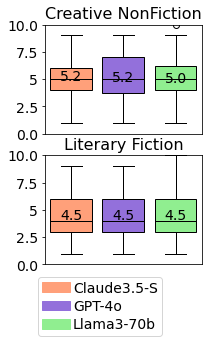

In [72]:
domains = Counter([d["type"] for d in data])
models = Counter([d["source"] for d in data])

colors = ["#FFA07A", "#9370DB", "#90EE90"]

pre_edit_scores = []
for domain in domains:
    result_row = {"domain": domain, "N": len([d for d in data if d["type"] == domain])}
    for model in models:
        entries = [d["creativity_pre_score"] for d in data if d["type"] == domain and d["source"] == model]
        mean = np.mean(entries)
        stderr = np.std(entries) / np.sqrt(len(entries))

        result_row[model] = f"{mean:.2f} ({stderr:.2f})"

    entries = [d["creativity_pre_score"] for d in data if d["type"] == domain]
    mean = np.mean(entries)
    stderr = np.std(entries) / np.sqrt(len(entries))
    result_row["Overall"] = f"{mean:.2f} ({stderr:.2f})"
    pre_edit_scores.append(result_row)

fig, axs = plt.subplots(2, 1, figsize=(3, 4))
domains = sorted(domains.keys())
for i, domain in enumerate(domains):
    ax = axs[i]
    data_domain = [d for d in data if d["type"] == domain]
    for j, model in enumerate(models):
        data_model = [d for d in data_domain if d["source"] == model]
        ax.boxplot([d["creativity_pre_score"] for d in data_model], positions=[j], patch_artist=True, boxprops=dict(facecolor= colors[j], color='black'), whiskerprops=dict(color='black'), medianprops=dict(color='black'), capprops=dict(color='black'), widths=0.8)
        # add the mean in black
        mean = np.mean([d["creativity_pre_score"] for d in data_model])
        ax.text(j, mean, f"{mean:.1f}", ha='center', va='center', fontsize=14)
    ax.set_title(domain, fontsize=16)
    ax.set_ylim(1, 10)
    ax.set_yticks([0.0, 2.5, 5, 7.5, 10.0], [0.0, 2.5, 5, 7.5, 10.0], fontsize=14)
    ax.set_xticks([])
# legend for the models
# axs[-1].set_xticks(range(len(models)), models.keys(), fontsize=12)
# use legend instead at the bottom with 3 columns
fig.tight_layout(h_pad=-0.5, w_pad=0)
fig.legend(handles=[mpatches.Patch(color=colors[i], label=model_clean_names[model]) for i, model in enumerate(models)], loc='lower left', bbox_to_anchor=(0.16, -0.205), ncol=1, fontsize=14, handletextpad=0.2, labelspacing=0.3, borderpad=0.3)
plt.savefig("figures/Figure_Pre_Scores_Domains.pdf", bbox_inches='tight')
plt.show()

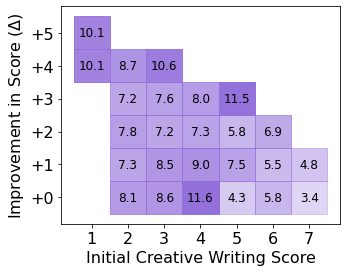

In [83]:
# Counter([d["creativity_diff_score"] for d in data])
# plot a 2-d pixel plot: x-axis pre-score, y-axis is diff score, color is number of edits
color = "#9370DB"
pre_scores = list(range(1, 8))
diff_scores = list(range(0, 6))

edit_counts = np.zeros((7, 6))
for i, pre_score in enumerate(pre_scores):
    for j, diff_score in enumerate(diff_scores):
        this_samples = [len(d["fine_grained_edits"]) for d in data if d["creativity_z_score_pre_int"] == pre_score and d["creativity_z_score_diff"] == diff_score]

        if len(this_samples) > 5:
            edit_counts[i, j] = np.mean(this_samples)
        else:
            edit_counts[i, j] = 0

# 9370DB use this color, with an alpha of 0.0 for 0 value, and 1.0 for max value
plt.figure(figsize=(5, 4))
for i, pre_score in enumerate(pre_scores):
    for j, diff_score in enumerate(diff_scores):
        alpha = edit_counts[i, j] / edit_counts.max()
        # print([i, j])
        plt.fill_between([pre_score-0.5, pre_score+0.5], [diff_score-0.5, diff_score-0.5], [diff_score+0.5, diff_score+0.5], color=color, alpha=alpha)
        if edit_counts[i, j] > 0:
            plt.text(pre_score, diff_score, f"{edit_counts[i, j]:.1f}", ha='center', va='center', fontsize=12, color='black')
plt.xlabel('Initial Creative Writing Score', fontsize=16)
plt.ylabel('Improvement in Score ($\Delta$)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks([0, 1, 2, 3, 4, 5], ["+0", "+1", "+2", "+3", "+4", "+5"], fontsize=16)
plt.show()